In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import sys
from tqdm import tqdm

import tensorflow as tf

# <project_root>/ddnet/ddnet.py
sys.path.insert(0, os.path.join(os.path.abspath(''), '..', 'ddnet'))
import ddnet

Using TensorFlow backend.


# Initialize the setting

In [2]:
random.seed(123)

# directory that contains pickle files
train_data_dir = os.path.join(os.path.abspath(''), '..', 'data', 'openpose_zeros_25')
test_data_dir = os.path.join(os.path.abspath(''), '..', 'data', 'openpose_mixing_hand_25')

# Helper functions

In [3]:
def data_generator(T, C, le, exclude_labels=[]):
    """
    Generate X (list of arrays) and Y (array) from a dict 
    """
    poses = []
    labels = []
    for p, L in zip(T['pose'], T['label']):
        if L not in exclude_labels:
            poses.append(p)
            labels.append(L)
    
    X = poses # list of arrays
    Y = np.zeros(shape=(len(labels), C.clc_num)) # 2D array one-hot encoding of labels
    Y[range(Y.shape[0]), le.transform(labels)] = 1
    return X, Y

In [4]:
# helper functions for plotting
# history is a history object from keras
def plot_accuracy(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()  

## Load and Preprocess Data

In [5]:
Train = pickle.load(open(os.path.join(train_data_dir, "GT_train_1.pkl"), "rb"))
Test = pickle.load(open(os.path.join(test_data_dir, "GT_test_1.pkl"), "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])
print("Classses: ", len(le.classes_), le.classes_)

Classses:  21 ['brush_hair' 'catch' 'clap' 'climb_stairs' 'golf' 'jump' 'kick_ball'
 'pick' 'pour' 'pullup' 'push' 'run' 'shoot_ball' 'shoot_bow' 'shoot_gun'
 'sit' 'stand' 'swing_baseball' 'throw' 'walk' 'wave']


In [6]:
C = ddnet.DDNetConfig(frame_length=32, num_joints=15, joint_dim=2, num_classes=21, num_filters=32)

X, Y = data_generator(Train,C,le)
X_test,Y_test = data_generator(Test,C,le)

print(len(X), X[0].shape, Y.shape)
print(len(X_test), X_test[0].shape, Y_test.shape)

497 (40, 25, 2) (497, 21)
195 (40, 25, 2) (195, 21)


### Cleaning and transforming OpenPose outputs

In [8]:
cleaner = ddnet.OpenPoseDataCleaner(copy=True, filter_joint_idx=ddnet.OP_HAND_PICKED_GOOD_JOINTS)

In [9]:
# filter points that have too many nans
def filter_many_nan_points(X, Y, nan_thres=0.5):
    """
    Input use 0 to indicate nan
    """
    X_filtered = []
    Y_filtered = []
    for p, y in zip(X, Y):
        if cleaner.count_nan(cleaner.make_nan(p)) / p.size <= nan_thres:
            X_filtered.append(p)
            Y_filtered.append(y)
    Y_filtered = np.array(Y_filtered)
    assert len(X_filtered) == Y_filtered.shape[0]
    return X_filtered, Y_filtered

X_filtered, Y_filtered = filter_many_nan_points(X, Y)
print(len(X_filtered))

# test data
X_test_filtered, Y_test_filtered = filter_many_nan_points(X_test, Y_test)
print(len(X_test_filtered))

414
195


In [10]:
# cleaning and data augmentation
X_clean, Y_clean = cleaner.augment_XY(X_filtered, Y_filtered, factor=5)
X_test_clean, Y_test_clean = cleaner.augment_XY(X_test_filtered, Y_test_filtered, factor=1)

print(len(X_clean), X_clean[0].shape, Y_clean.shape)
print(len(X_test_clean), X_test_clean[0].shape, Y_test_clean.shape)

2070 (40, 15, 2) (2070, 21)
195 (40, 15, 2) (195, 21)


In [11]:
# commit changes
X_input, Y_input = X_clean, Y_clean
X_test_input, Y_test_input = X_test_clean, Y_test_clean

### DDNet's preprocess and config

In [12]:
# redefine config with new # of joints
C = ddnet.DDNetConfig(frame_length=32, num_joints=X_input[0].shape[1], joint_dim=2, num_classes=21, num_filters=64)

X_0, X_1 = ddnet.preprocess_batch(X_input, C)
X_test_0, X_test_1 = ddnet.preprocess_batch(X_test_input, C)

# Train, Test 

In [13]:
# rescale sample weight to balance classes
def get_sample_weight(Y):
    cls_ids = np.argmax(Y, axis=1)
    assert cls_ids.shape[0] == Y.shape[0]
    cls_histo = np.array([np.count_nonzero(cls_ids==i) for i in range(Y.shape[1])])
    cls_weight = np.max(cls_histo) / cls_histo # balanced
    print(cls_histo)
    print(cls_weight)
    sample_weight = cls_weight[cls_ids]
    assert sample_weight.shape[0] == Y.shape[0]
    return sample_weight

In [14]:
sample_weight = get_sample_weight(Y_input)
print(sample_weight.shape)
print(sample_weight[:10])

[ 40 145  80 125 150  65  55  95 180 180 120  80  45 140  70  60  45 125
  90 105  75]
[4.5        1.24137931 2.25       1.44       1.2        2.76923077
 3.27272727 1.89473684 1.         1.         1.5        2.25
 4.         1.28571429 2.57142857 3.         4.         1.44
 2.         1.71428571 2.4       ]
(2070,)
[1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]


In [15]:
DD_Net = ddnet.create_DDNet(C)
# DD_Net.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



### Train and plot loss/accuracy

In [ ]:
import keras
from keras import backend as K
from keras.optimizers import *

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.Session(config=config)
K.set_session(sess)

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)

history1 = DD_Net.fit([X_0,X_1],Y_input,
                    batch_size=len(Y_input),
                    epochs=1000,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test_input),
                    sample_weight=sample_weight
                    )

lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history2 = DD_Net.fit([X_0,X_1],Y_input,
                    batch_size=len(Y_input),
                    epochs=400,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test_input),
                    sample_weight=sample_weight
                    )


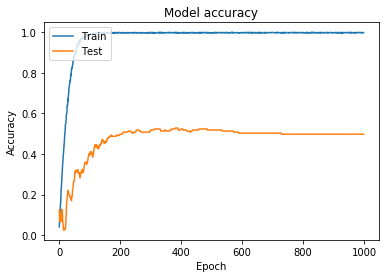

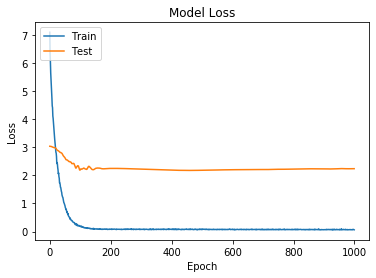

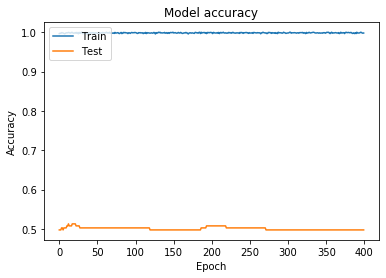

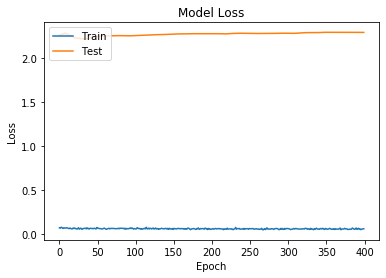

In [17]:
%matplotlib inline
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

### Plot confusion matrix

In [18]:
Y_test_pred = DD_Net.predict([X_test_0, X_test_1])

[[ 0  0  2  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  2  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0  1  1  0  1  0  0  0  0  0  2  2  0]
 [ 0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  1  0  1  0  1  0  1  1  0  0  0  0  0  0  0  0]
 [ 0  1  0  1  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 2  0  4  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  2  6]
 [ 0  0  0  0  0  0  0  0  0 13  3  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  1  5  0  0  1  0  0  0  1  0  1  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  3  0]
 [ 0  1  0  0  0  0  0  0  0  1  0  0  2  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0  8  1  0  0  0  0  0]
 [ 0  0  0

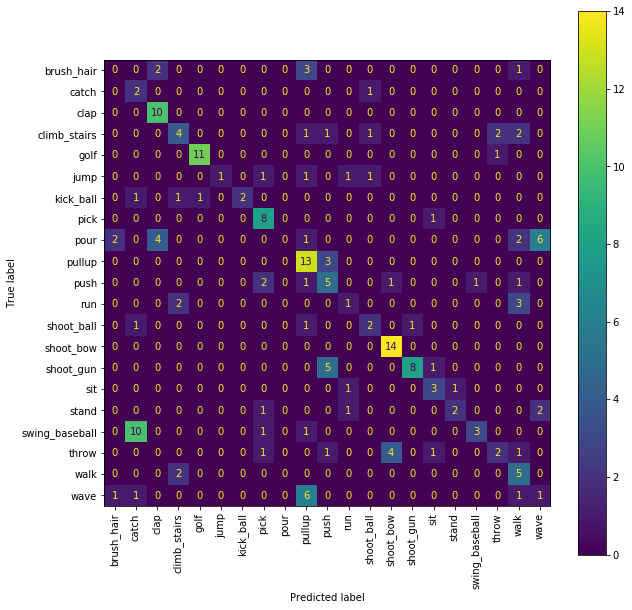

In [19]:
Y_test_pred_cls = np.argmax(Y_test_pred, axis=1)
Y_test_cls = np.argmax(Y_test_input, axis=1)
Y_test_cls[:10], Y_test_pred_cls[:10]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
normalize= None # 'true'
cm = confusion_matrix(Y_test_cls, Y_test_pred_cls, normalize=normalize)
print(cm)
# print(np.sum(np.diagonal(cm)) / np.sum(cm)) # accuracy

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation=90, ax=ax)

### Save model to disk

In [ ]:
model_path = 'jhmdb_openpose_model_mixed_11.h5'
ddnet.save_DDNet(DD_Net, model_path)

### Refit using Training + Test Data

In [ ]:
print(Y_input.shape, Y_test_input.shape)
X_refit = X_input + X_test_input
Y_refit = np.concatenate([Y_input, Y_test_input])
assert len(X_refit) == Y_refit.shape[0]
print(len(X_refit))
refit_sample_weight = get_sample_weight(Y_refit)

In [ ]:
X_refit_0, X_refit_1 = ddnet.preprocess_batch(X_refit, C)

In [ ]:
# create a new net
refit_net = ddnet.create_DDNet(C)

lr = 1e-3
refit_net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)

history1 = refit_net.fit([X_refit_0,X_refit_1],Y_refit,
                    batch_size=len(Y_refit),
                    epochs=800,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    sample_weight=refit_sample_weight
                    )

lr = 1e-4
refit_net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)

history2 = refit_net.fit([X_refit_0,X_refit_1],Y_refit,
                    batch_size=len(Y_refit),
                    epochs=500,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    sample_weight=refit_sample_weight
                    )


In [ ]:
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

### Save/Load Model

In [ ]:
with open('jhmdb_le.pkl', 'wb') as f:
    pickle.dump(le, f)
le.classes_.tolist()

In [ ]:
model_path = 'jhmdb_openpose_model_refit.h5'
ddnet.save_DDNet(refit_net, model_path)

In [ ]:
# Load the model back from disk
new_net = ddnet.load_DDNet(model_path)
# Evaluate against test set, you should get the same accuracy
new_net.evaluate([X_test_0,X_test_1],Y_test)